In [338]:
Title = "Daily Dozen: personal diet diary"

In [439]:
import pandas as pd
from bs4 import BeautifulSoup
import requests

In [440]:
#get the soup from the website
url = requests.get("https://nutritionfacts.org/daily-dozen/")
soup = BeautifulSoup(url.content, "html.parser")

In [441]:
#find the needed data in the soup and make lists
dd_grid = soup.find_all(attrs={"class":"daily-dozen-grid mt-3"})
dd = [foodgroup.text.strip() for entry in dd_grid for foodgroup in entry.find_all("h3")]
servings_and_examples = [serving.text.strip() for entry in dd_grid for serving in entry.find_all("p")]
examples = servings_and_examples[1::2]
servings = servings_and_examples[::2]

In [442]:
#make a dataframe out of the individual lists
df_dd = pd.DataFrame({
   "food_group": dd,
    "servings": servings, 
    "examples": examples})

df_dd['servings'] = df_dd['servings'].str.extract('(\d+)').astype(float)

In [443]:
df_dd["examples"] = df_dd["examples"].astype("string")
print(df_dd.dtypes)

food_group            object
servings             float64
examples      string[python]
dtype: object


In [444]:
#convert the 60 oz of drinks to five servings (five glasses - mugs of water, tea etc)
df_dd.loc[df_dd['food_group'] == "Beverages", 'servings'] = 5
#drop the exercise column, since it is not a foodgroup
df_dd = df_dd.drop(index=11)
print(df_dd)

                food_group  servings                                examples
0                    Beans       3.0     e.g. ½ c. cooked beans, ¼ c. hummus
1                  Berries       1.0   e.g. ½ c. fresh or frozen, ¼ c. dried
2             Other Fruits       3.0   e.g. 1 medium fruit, ¼ c. dried fruit
3   Cruciferous Vegetables       1.0   e.g. ½ c. chopped, 1 tbsp horseradish
4                   Greens       2.0              e.g. 1 c. raw, ½ c. cooked
5         Other Vegetables       2.0           e.g. ½ c. nonleafy vegetables
6                 Flaxseed       1.0                      e.g. 1 tbsp ground
7           Nuts and Seeds       1.0       e.g. ¼ c. nuts, 2 tbsp nut butter
8         Herbs and Spices       1.0                     e.g. ¼ tsp turmeric
9             Whole Grains       3.0  e.g. ½ c. hot cereal, 1 slice of bread
10               Beverages       5.0  e.g. Water, green tea,
			hibiscus tea


In [445]:
#change the foodgroups to be in line with the data later on
df_dd.at[6, 'food_group'] = 'Flaxseeds'
df_dd.at[7, 'food_group'] = 'Nuts'
df_dd.at[8, 'food_group'] = 'Spices'

In [346]:
print(df_dd)

                food_group  servings                                examples
0                    Beans       3.0     e.g. ½ c. cooked beans, ¼ c. hummus
1                  Berries       1.0   e.g. ½ c. fresh or frozen, ¼ c. dried
2             Other Fruits       3.0   e.g. 1 medium fruit, ¼ c. dried fruit
3   Cruciferous Vegetables       1.0   e.g. ½ c. chopped, 1 tbsp horseradish
4                   Greens       2.0              e.g. 1 c. raw, ½ c. cooked
5         Other Vegetables       2.0           e.g. ½ c. nonleafy vegetables
6                Flaxseeds       1.0                      e.g. 1 tbsp ground
7                     Nuts       1.0       e.g. ¼ c. nuts, 2 tbsp nut butter
8                   Spices       1.0                     e.g. ¼ tsp turmeric
9             Whole Grains       3.0  e.g. ½ c. hot cereal, 1 slice of bread
10               Beverages       5.0  e.g. Water, green tea,
			hibiscus tea


In [347]:
import json

In [348]:
json_file_path = '/Users/lottedieleman/Downloads/dailydozen_backup-1.json'

# Read the JSON file into a DataFrame
dd_data = pd.read_json(json_file_path, lines=True)
dd_data = dd_data.drop("tweaks", axis=1)
dd_data = dd_data.drop("eveningWeight", axis=1)
dd_data = dd_data.drop("morningWeight", axis=1)

# Display the DataFrame
print(dd_data.head())

       Date                                         dailyDozen
0  20240102  {'Spices': 1, 'Whole Grains': 1, 'Other Fruits...
1  20240103  {'Spices': 1, 'Whole Grains': 1, 'Other Fruits...
2  20240104  {'Spices': 1, 'Whole Grains': 1, 'Other Fruits...
3  20240105  {'Spices': 1, 'Whole Grains': 3, 'Other Fruits...
4  20240106  {'Spices': 1, 'Whole Grains': 2, 'Other Fruits...


In [349]:
#adjust the dataframe
def json_to_dataframe(df, keys): 
    new_df = pd.json_normalize(df['dailyDozen'])
    new_df[keys] = new_df[keys]

new_keys = ["Spices", "Whole Grains", "Other Fruits", "Nuts", "Beans", "Cruciferous Vegetables", "Flaxseeds", "Other Vegetables", "Beverages", "Berries", "Exercise", "Greens"]   

for key in new_keys:
    dd_data[key] = pd.json_normalize(dd_data['dailyDozen'])[key]
        
dd_data = dd_data.drop(columns='dailyDozen')
print(dd_data.head())

       Date  Spices  Whole Grains  Other Fruits  Nuts  Beans  \
0  20240102       1             1             1     1      1   
1  20240103       1             1             2     1      1   
2  20240104       1             1             0     1      3   
3  20240105       1             3             0     1      3   
4  20240106       1             2             1     1      3   

   Cruciferous Vegetables  Flaxseeds  Other Vegetables  Beverages  Berries  \
0                       0          0                 2          5        1   
1                       1          0                 2          5        1   
2                       1          0                 2          4        1   
3                       1          0                 2          4        1   
4                       0          1                 2          5        1   

   Exercise  Greens  
0         0       0  
1         1       1  
2         0       0  
3         0       0  
4         1       0  


In [350]:
#check and change data types for datetime
from datetime import datetime

#print(dd_data.isnull().sum())
#print(dd_data.describe())

dd_data["Date"] = pd.to_datetime(dd_data["Date"].astype(str), format='%Y%m%d')
print(dd_data.head())

        Date  Spices  Whole Grains  Other Fruits  Nuts  Beans  \
0 2024-01-02       1             1             1     1      1   
1 2024-01-03       1             1             2     1      1   
2 2024-01-04       1             1             0     1      3   
3 2024-01-05       1             3             0     1      3   
4 2024-01-06       1             2             1     1      3   

   Cruciferous Vegetables  Flaxseeds  Other Vegetables  Beverages  Berries  \
0                       0          0                 2          5        1   
1                       1          0                 2          5        1   
2                       1          0                 2          4        1   
3                       1          0                 2          4        1   
4                       0          1                 2          5        1   

   Exercise  Greens  
0         0       0  
1         1       1  
2         0       0  
3         0       0  
4         1       0  


In [351]:
#drop the column Exercise, since it is not an actual foodgroup
#dd_data = dd_data.drop(columns=['Exercise'])

In [356]:
# on average: how much of the daily servings do I reach a day, per foodgroup, in the whole timeframe of recorded data? 

def percentage_reached(df_eaten):
    avg = []
    fg = []
    df_eaten = df_eaten.drop(columns=["Date"])
    for col in df_eaten:
        avg.append(dd_data[col].mean())
        fg.append(col)
    
    df_eaten_new = pd.DataFrame({
        "food_group" : fg, 
        "avg_eaten" : avg})
    
    df_all_info = pd.merge(df_eaten_new, df_dd, on='food_group')
    
    df_all_info["percentage"] = df_all_info["avg_eaten"] / df_all_info["servings"] * 100
    
    return df_all_info.sort_values(by='percentage')

In [357]:
percentage_reached(dd_data)

,food_group,avg_eaten,servings,examples,percentage
2,Other Fruits,1.046512,3.0,"e.g. 1 medium fruit, ¼ c. dried fruit",34.883721
6,Flaxseeds,0.395349,1.0,e.g. 1 tbsp ground,39.534884
10,Greens,0.813953,2.0,"e.g. 1 c. raw, ½ c. cooked",40.697674
9,Berries,0.511628,1.0,"e.g. ½ c. fresh or frozen, ¼ c. dried",51.162791
1,Whole Grains,2.069767,3.0,"e.g. ½ c. hot cereal, 1 slice of bread",68.992248
4,Beans,2.139535,3.0,"e.g. ½ c. cooked beans, ¼ c. hummus",71.317829
5,Cruciferous Vegetables,0.744186,1.0,"e.g. ½ c. chopped, 1 tbsp horseradish",74.418605
3,Nuts,0.790698,1.0,"e.g. ¼ c. nuts, 2 tbsp nut butter",79.069767
8,Beverages,4.162791,5.0,"e.g. Water, green tea, hibiscus tea",83.255814
7,Other Vegetables,1.767442,2.0,e.g. ½ c. nonleafy vegetables,88.372093


In [359]:
#percentage-wise, how does my intake of different foodgroups evolve overtime? 
import matplotlib.pyplot as plt

def intake_over_time(df_eaten, df_dd):
    plt.figure(figsize=(15, 6))

    for fg in df_dd['food_group']:
        plt.plot(df_eaten['Date'], (df_eaten[fg] / df_dd.loc[df_dd['food_group'] == fg, 'servings'].iloc[0]), label=fg)

    plt.title('Foodgroup Intake over Time')
    plt.legend()
    plt.show()

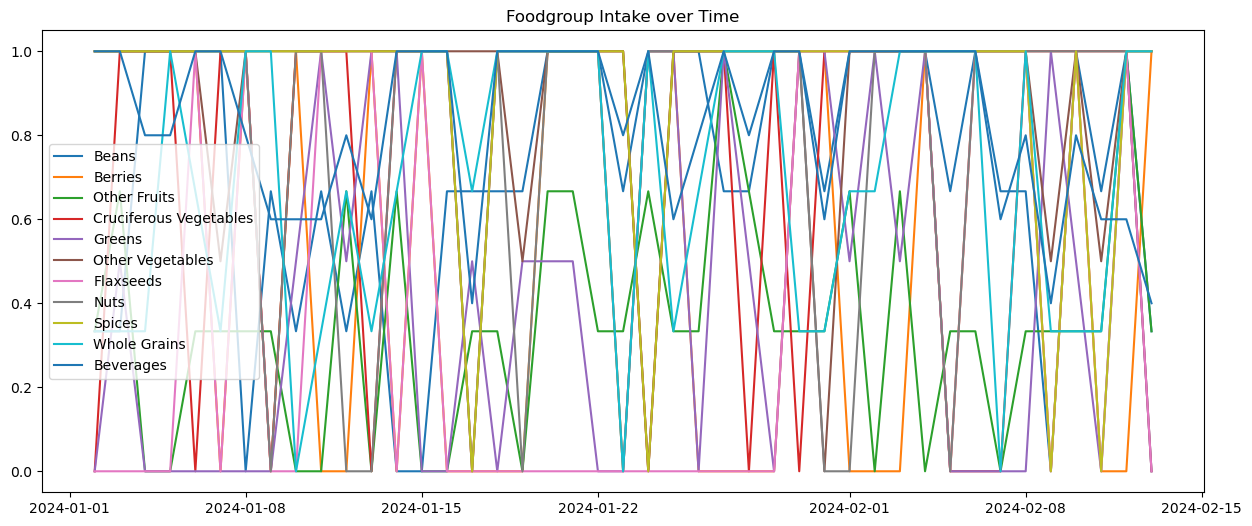

In [360]:
intake_over_time(dd_data, df_dd)

In [434]:
#percentage-wise, how does my intake of single foodgroups evolve overtime? 

def intake_over_time_single(df_eaten, df_dd, fg):
    plt.figure(figsize=(15, 6))
    plt.plot(df_eaten['Date'], (df_eaten[fg] / df_dd.loc[df_dd['food_group'] == fg, 'servings'].iloc[0]), label=fg)
    plt.title(f' {fg} Intake over Time')
    plt.legend()
    plt.show()

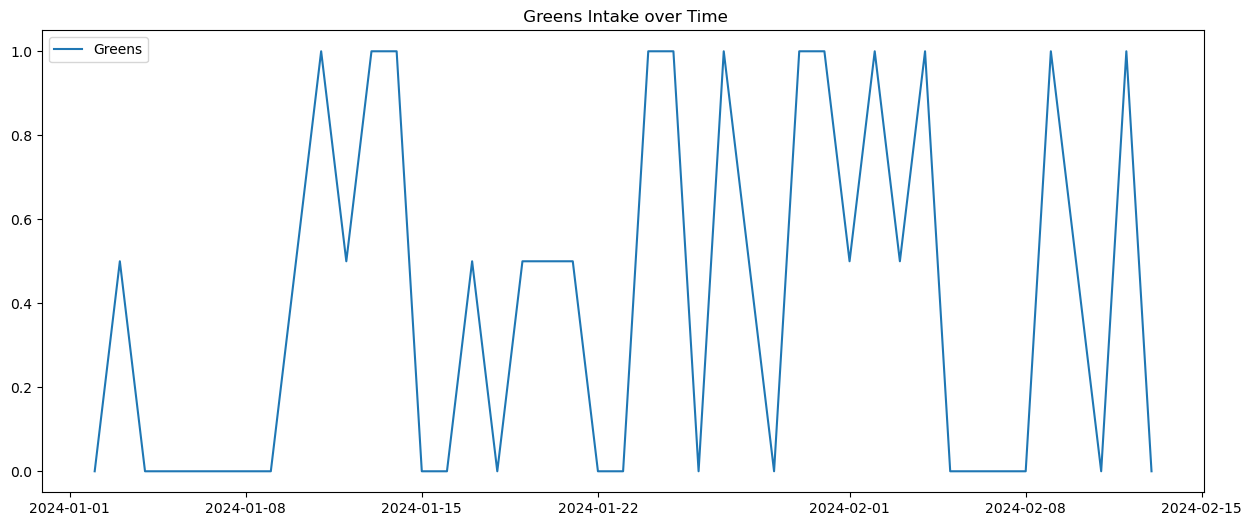

In [435]:
intake_over_time_single(dd_data, df_dd, "Greens")

In [427]:
#let's try and find out, whether day of the week has an influence on foodgroup intake 

dd_data.head()
dd_data['day_of_week'] = dd_data['Date'].dt.day_name()

In [450]:
# plot the average intake per weekday of a single foodgroup of choice

def intake_per_day_single(df_eaten, df_dd, fg):
    
    #y should the percentage of intake reached
    #x should be the days of the week
    plt.figure(figsize=(15, 6))

    x_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    y = (df_eaten[fg].groupby(df_eaten["day_of_week"]).mean().reindex(x_labels)) / df_dd.loc[df_dd['food_group'] == fg, 'servings'].iloc[0]
    
    plt.bar(x_labels, y, color='skyblue')
    plt.title(f'{fg}: Weekly Intake')
    plt.ylim(0, 1)
    plt.show()

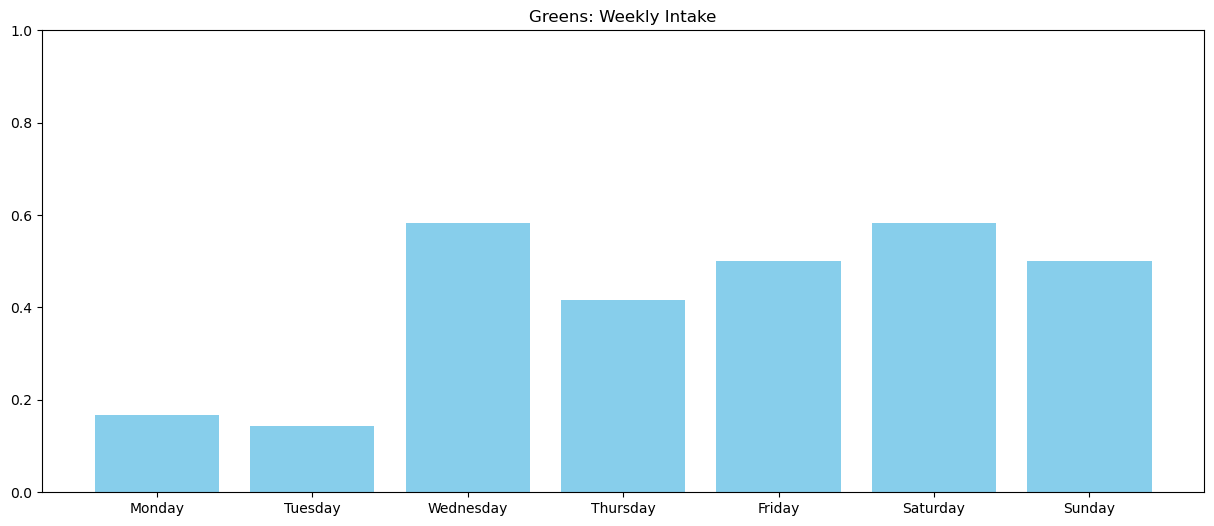

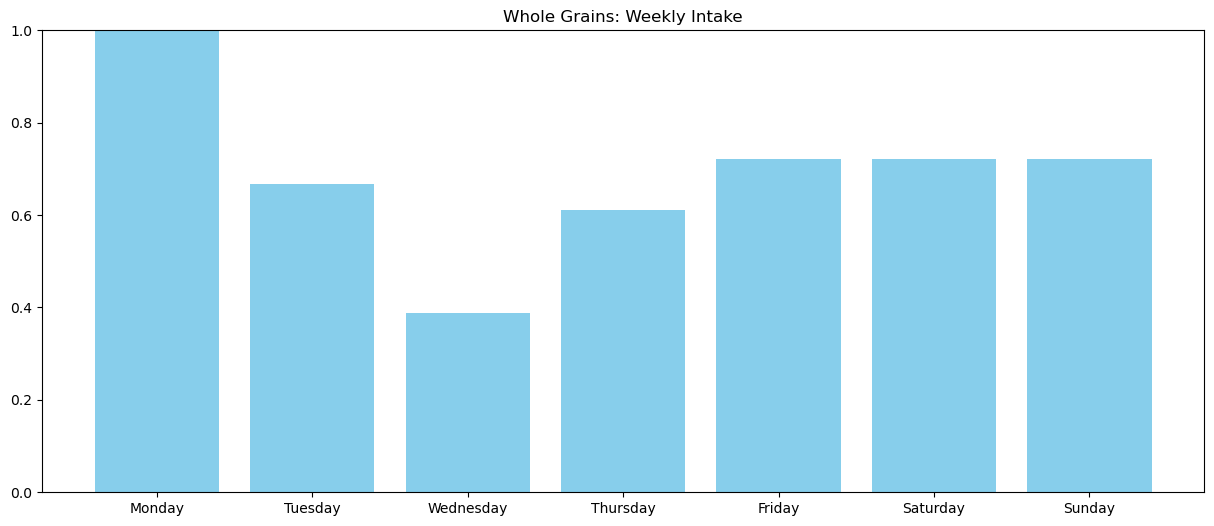

In [451]:
intake_per_day_single(dd_data, df_dd, "Greens")
intake_per_day_single(dd_data, df_dd, "Whole Grains")

In [459]:
import matplotlib.pyplot as plt

def intake_per_day_all(df_eaten, df_dd):
    plt.figure(figsize=(15, 6))
    
    # Define the order of days of the week
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    # Initialize an empty dictionary to store percentage intake for each food group
    percentage_intake_all = {}
    
    # Iterate over each food group
    for fg in df_dd['food_group'].unique():
        # Calculate the average intake per weekday for the current food group
        percentage_intake = (df_eaten[fg].groupby(df_eaten["day_of_week"]).mean().reindex(day_order)) / df_dd.loc[df_dd['food_group'] == fg, 'servings'].iloc[0]
     
        # Store the percentage intake in the dictionary
        percentage_intake_all[fg] = percentage_intake
    
    # Plotting the bar chart for each food group
    for fg, percentage_intake in percentage_intake_all.items():
        plt.bar(percentage_intake.index, percentage_intake.values, label=fg)
    
    # Adding labels and title
    plt.xlabel('Day of the Week')
    plt.ylabel('Percentage of Intake Reached')
    plt.title('Weekly Intake for All Food Groups')
    
    # Set y-axis limits
    plt.ylim(0, 1)
    
    # Add legend
    plt.legend()
    
    # Display the plot
    plt.show()

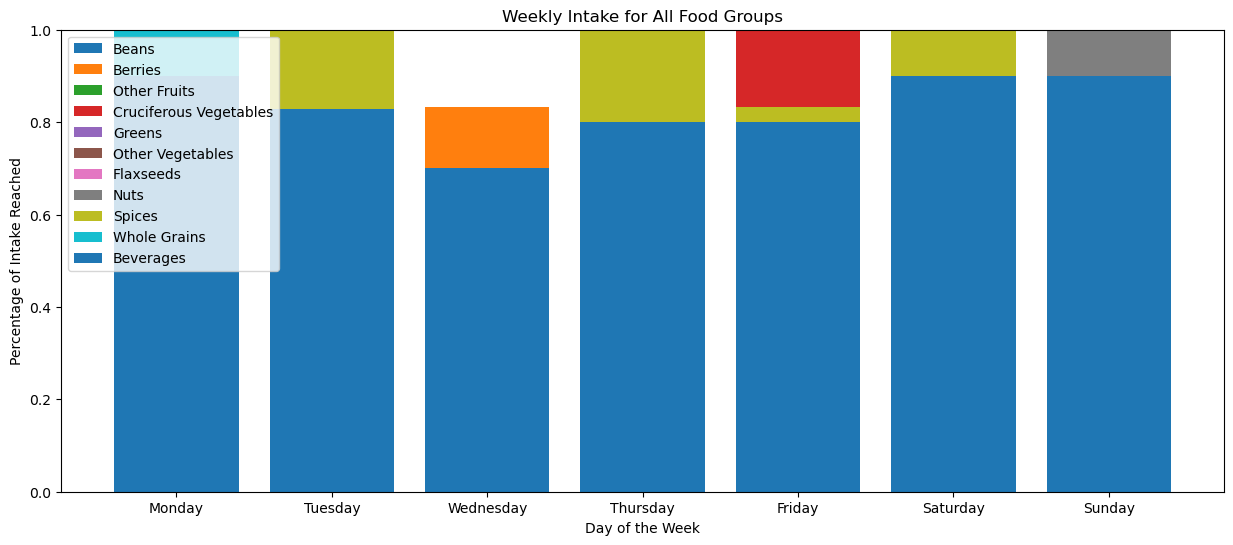

In [463]:
intake_per_day_all(dd_data, df_dd)

In [466]:
import matplotlib.pyplot as plt
import numpy as np

def intake_per_day_all_2(df_eaten, df_dd):
    plt.figure(figsize=(20, 6))
    
    # Define the order of days of the week
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    # Calculate the width of each bar
    bar_width = 0.8 / len(day_order)
    
    # Initialize an empty dictionary to store percentage intake for each food group
    percentage_intake_all = {}
    
    # Iterate over each food group
    for i, fg in enumerate(df_dd['food_group'].unique()):
        # Calculate the x-coordinates for the bars of the current food group
        x_values = np.arange(len(day_order)) + i * bar_width
        
        # Calculate the percentage intake for the current food group
        percentage_intake = (df_eaten[fg].groupby(df_eaten["day_of_week"]).mean().reindex(day_order)) / df_dd.loc[df_dd['food_group'] == fg, 'servings'].iloc[0]
        
        # Plot the bars for the current food group
        plt.bar(x_values, percentage_intake.values, width=bar_width, label=fg)
    
    # Adding labels and title
    plt.xlabel('Day of the Week')
    plt.ylabel('Percentage of Intake Reached')
    plt.title('Weekly Intake for All Food Groups')
    
    # Set x-ticks to the middle of each group
    plt.xticks(np.arange(len(day_order)) + 0.5 * bar_width * (len(df_dd['food_group'].unique()) - 1), day_order)
    
    # Set y-axis limits
    plt.ylim(0, 1)
    
    # Add legend
    plt.legend()
    
    # Display the plot
    plt.show()


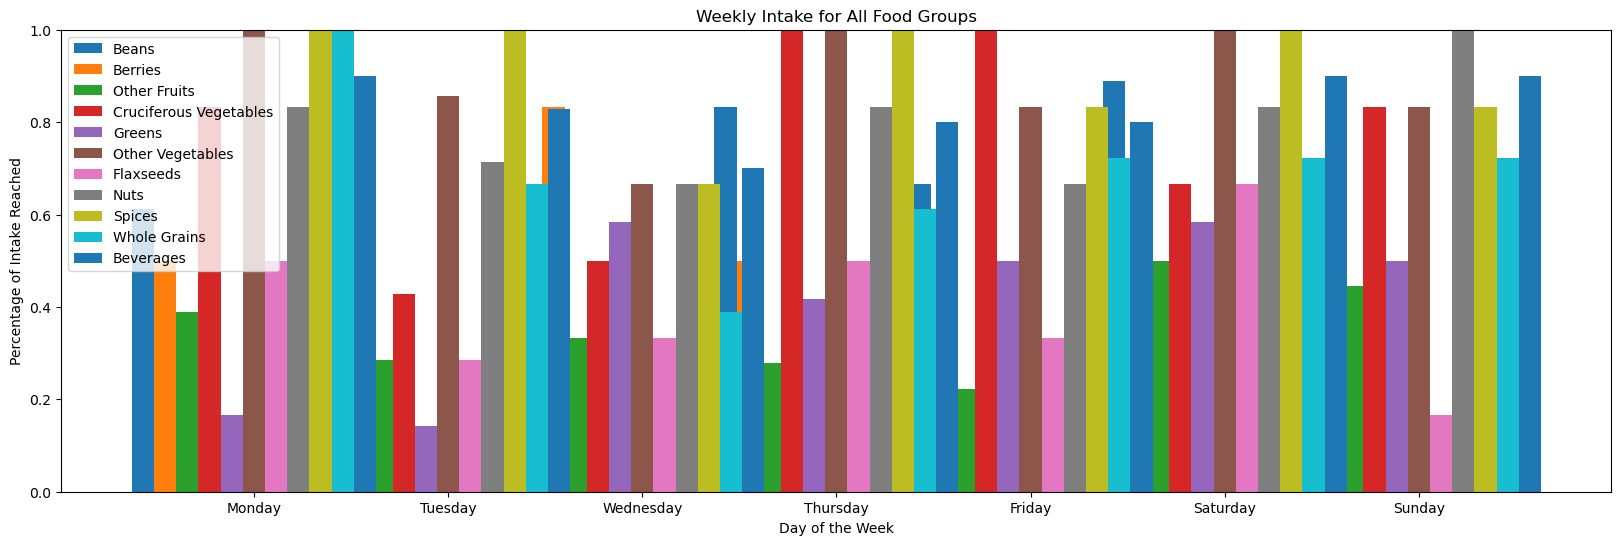

In [467]:
intake_per_day_all_2(dd_data, df_dd)